<a href="https://colab.research.google.com/github/vishalinipg/Hack4Health/blob/main/Dental_Caries_Techno_Voyagers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
GPU Available: True
GPU: Tesla T4


In [2]:
!pip install -q segmentation-models-pytorch albumentations grad-cam efficientnet-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.8 MB/s eta 0:00:00


In [3]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.spatial.distance import directed_hausdorff

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✓ Device: {device}')

✓ Device: cuda


In [16]:
BASE_PATH = '/content/drive/MyDrive/Dataset'

CARRIES_DIR = os.path.join(BASE_PATH, 'Carries')
NORMAL_DIR = os.path.join(BASE_PATH, 'Normal')

if os.path.exists(CARRIES_DIR):
    print(f"✓ Found: {CARRIES_DIR}")
else:
    print(f"NOT FOUND: {CARRIES_DIR}")
    print("Please update BASE_PATH!")

if os.path.exists(NORMAL_DIR):
    print(f"✓ Found: {NORMAL_DIR}")
else:
    print(f"NOT FOUND: {NORMAL_DIR}")

# Hyperparameters (optimized for speed + accuracy)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
NUM_CLASSES = 3  # No/Mild/Severe

✓ Found: /content/drive/MyDrive/Dataset/Carries
✓ Found: /content/drive/MyDrive/Dataset/Normal


In [17]:
class DentalDataset(Dataset):
    def __init__(self, carries_dir, normal_dir, transform=None):
        self.transform = transform
        self.data = []

        # Load Carries
        for img_path in glob.glob(os.path.join(carries_dir, '*.png')):
            if '-mask' not in img_path:
                mask_path = img_path.replace('.png', '-mask.png')
                if os.path.exists(mask_path):
                    self.data.append({'image': img_path, 'mask': mask_path, 'caries': 1})

        # Load Normal
        for img_path in glob.glob(os.path.join(normal_dir, '*.png')):
            if '-mask' not in img_path:
                mask_path = img_path.replace('.png', '-mask.png')
                if os.path.exists(mask_path):
                    self.data.append({'image': img_path, 'mask': mask_path, 'caries': 0})

        caries_cnt = sum(1 for d in self.data if d['caries'])
        normal_cnt = len(self.data) - caries_cnt
        print(f"✓ Caries: {caries_cnt} | Normal: {normal_cnt} | Total: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = cv2.imread(item['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(item['mask'], cv2.IMREAD_GRAYSCALE)

        # Severity classification
        ratio = np.sum(mask > 127) / mask.size
        label = 0 if ratio == 0 else (1 if ratio < 0.08 else 2)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']

        mask = (mask > 127).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask, label, os.path.basename(item['image'])

# Transforms
train_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.CLAHE(p=0.3),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

val_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

In [18]:
#Create datasets
full_dataset = DentalDataset(CARRIES_DIR, NORMAL_DIR)

train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_idx, val_idx = random_split(range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))

class SubDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset, self.indices, self.transform = dataset, indices.indices, transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        item = self.dataset.data[self.indices[idx]]
        image = cv2.cvtColor(cv2.imread(item['image']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(item['mask'], cv2.IMREAD_GRAYSCALE)
        ratio = np.sum(mask>127)/mask.size
        label = 0 if ratio==0 else (1 if ratio<0.08 else 2)
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        mask = torch.from_numpy((mask>127).astype(np.float32)).unsqueeze(0)
        return image, mask, label, os.path.basename(item['image'])

train_dataset = SubDataset(full_dataset, train_idx, train_tfm)
val_dataset = SubDataset(full_dataset, val_idx, val_tfm)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ Train: {len(train_dataset)} | Val: {len(val_dataset)}")

✓ Caries: 566 | Normal: 564 | Total: 1130
✓ Train: 904 | Val: 226


In [19]:
class MultiTaskDentalNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        #Segmentation branch
        self.encoder = smp.Unet(
            encoder_name="efficientnet-b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )

        #Classification branch
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.clf_conv1 = nn.Conv2d(320, 256, 1)  # EfficientNet-b0 last channel
        self.clf_conv2 = nn.Conv2d(112, 256, 1)  # EfficientNet-b0 4th block

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Encoder features
        features = self.encoder.encoder(x)

        # Segmentation
        seg_out = self.encoder(x)

        # Classification
        feat1 = self.global_pool(self.clf_conv1(features[-1])).flatten(1)
        feat2 = self.global_pool(self.clf_conv2(features[-2])).flatten(1)
        clf_out = self.classifier(torch.cat([feat1, feat2], 1))

        return seg_out, clf_out

model = MultiTaskDentalNet(NUM_CLASSES).to(device)
print(f"✓ Parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Parameters: 6,527,184


In [51]:
#Loss Functions and Optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        bce = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        return (self.alpha * (1-pt)**self.gamma * bce).mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)
        inter = (inputs * targets).sum()
        return 1 - (2*inter + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets):
        return 0.5*self.focal(inputs, targets) + 0.5*self.dice(inputs, targets)

class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    def forward(self, pred, target):
        n = pred.size(-1)
        log_preds = F.log_softmax(pred, -1)
        loss = -log_preds.sum(-1).mean()
        nll = F.nll_loss(log_preds, target, reduction='mean')
        return (1-self.smoothing)*nll + self.smoothing*loss/n

seg_criterion = CombinedLoss()
clf_criterion = LabelSmoothing(0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

In [21]:
def dice_coef(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    return (2*inter + smooth)/(pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.0):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + smooth)/(union + smooth)

def pixel_acc(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    return (pred == target).float().mean()

def sens_spec(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    TP = ((pred==1) & (target==1)).float().sum()
    TN = ((pred==0) & (target==0)).float().sum()
    FP = ((pred==1) & (target==0)).float().sum()
    FN = ((pred==0) & (target==1)).float().sum()
    return TP/(TP+FN+1e-7), TN/(TN+FP+1e-7)

In [22]:
def train_epoch(model, loader, optimizer, seg_crit, clf_crit, device, epoch):
    model.train()
    loss_sum = dice_sum = acc_sum = 0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    for imgs, masks, labels, _ in pbar:
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        seg_out, clf_out = model(imgs)

        seg_loss = seg_crit(seg_out, masks)
        clf_loss = clf_crit(clf_out, labels)
        loss = 0.6*seg_loss + 0.4*clf_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        with torch.no_grad():
            dice = dice_coef(seg_out, masks)
            acc = (clf_out.argmax(1)==labels).float().mean()

        loss_sum += loss.item()
        dice_sum += dice.item()
        acc_sum += acc.item()

        pbar.set_postfix({'loss':f'{loss.item():.4f}','dice':f'{dice.item():.4f}','acc':f'{acc.item():.4f}'})

    n = len(loader)
    return loss_sum/n, dice_sum/n, acc_sum/n

def validate(model, loader, seg_crit, clf_crit, device):
    model.eval()
    loss_sum = dice_sum = iou_sum = pacc_sum = sens_sum = spec_sum = 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for imgs, masks, labels, _ in tqdm(loader, desc='Validating'):
            imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

            seg_out, clf_out = model(imgs)
            loss = 0.6*seg_crit(seg_out, masks) + 0.4*clf_crit(clf_out, labels)

            dice = dice_coef(seg_out, masks)
            iou = iou_score(seg_out, masks)
            pacc = pixel_acc(seg_out, masks)
            sens, spec = sens_spec(seg_out, masks)

            probs = F.softmax(clf_out, 1)
            preds = clf_out.argmax(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            loss_sum += loss.item()
            dice_sum += dice.item()
            iou_sum += iou.item()
            pacc_sum += pacc.item()
            sens_sum += sens.item()
            spec_sum += spec.item()

    n = len(loader)
    return {
        'loss': loss_sum/n, 'dice': dice_sum/n, 'iou': iou_sum/n,
        'pixel_acc': pacc_sum/n, 'sens': sens_sum/n, 'spec': spec_sum/n,
        'clf_acc': accuracy_score(all_labels, all_preds),
        'clf_prec': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'clf_rec': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'clf_f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
        'labels': all_labels, 'preds': all_preds, 'probs': all_probs
    }

In [23]:
class DentalDataset(Dataset):
    def __init__(self, carries_dir, normal_dir, transform=None):
        self.transform = transform
        self.data = []

        #Load Carries
        for img_path in glob.glob(os.path.join(carries_dir, '*.png')):
            if '-mask' not in img_path:
                mask_path = img_path.replace('.png', '-mask.png')
                if os.path.exists(mask_path):
                    self.data.append({'image': img_path, 'mask': mask_path, 'caries': 1})

        #Load Normal
        for img_path in glob.glob(os.path.join(normal_dir, '*.png')):
            if '-mask' not in img_path:
                mask_path = img_path.replace('.png', '-mask.png')
                if os.path.exists(mask_path):
                    self.data.append({'image': img_path, 'mask': mask_path, 'caries': 0})

        caries_cnt = sum(1 for d in self.data if d['caries'])
        normal_cnt = len(self.data) - caries_cnt
        print(f"✓ Caries: {caries_cnt} | Normal: {normal_cnt} | Total: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = cv2.imread(item['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(item['mask'], cv2.IMREAD_GRAYSCALE)

        #Process mask as NumPy array FIRST
        mask_np = (mask > 127).astype(np.float32)

        #Severity classification logic
        ratio = np.sum(mask_np) / mask_np.size
        label = 0 if ratio == 0 else (1 if ratio < 0.08 else 2)

        #Apply Albumentations
        if self.transform:
            aug = self.transform(image=image, mask=mask_np)
            image, mask = aug['image'], aug['mask']
        else:
            image = torch.from_numpy(image).permute(2,0,1).float()
            mask = torch.from_numpy(mask_np)

        #Ensure consistent dimensions (1, H, W)
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask, label, os.path.basename(item['image'])

class SubDataset(Dataset):
    def __init__(self, dataset, subset, transform):
        self.dataset = dataset
        self.indices = subset.indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        item = self.dataset.data[self.indices[idx]]
        image = cv2.imread(item['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(item['mask'], cv2.IMREAD_GRAYSCALE)

        mask_np = (mask > 127).astype(np.float32)
        ratio = np.sum(mask_np) / mask_np.size
        label = 0 if ratio == 0 else (1 if ratio < 0.08 else 2)

        if self.transform:
            aug = self.transform(image=image, mask=mask_np)
            image, mask = aug['image'], aug['mask']
        else:
            image = torch.from_numpy(image).permute(2,0,1).float()
            mask = torch.from_numpy(mask_np)

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask, label, os.path.basename(item['image'])

In [24]:
#Create datasets
full_dataset = DentalDataset(CARRIES_DIR, NORMAL_DIR)

train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

#Use the fixed SubDataset class
train_dataset = SubDataset(full_dataset, train_subset, train_tfm)
val_dataset = SubDataset(full_dataset, val_subset, val_tfm)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ DataLoaders ready: Train: {len(train_dataset)} | Val: {len(val_dataset)}")

✓ Caries: 566 | Normal: 564 | Total: 1130
✓ DataLoaders ready: Train: 904 | Val: 226


In [25]:
#Training
history = {'train_loss':[], 'val_loss':[], 'train_dice':[], 'val_dice':[], 'train_acc':[], 'val_acc':[]}
best_dice = 0

print('\n'+'='*70)
print('TRAINING START'.center(70))
print('='*70+'\n')

for epoch in range(NUM_EPOCHS):
    train_loss, train_dice, train_acc = train_epoch(model, train_loader, optimizer, seg_criterion, clf_criterion, device, epoch)
    val_metrics = validate(model, val_loader, seg_criterion, clf_criterion, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_metrics['dice'])
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_metrics['clf_acc'])

    print(f"\nEpoch {epoch+1}:")
    print(f"Loss: {train_loss:.4f} → {val_metrics['loss']:.4f}")
    print(f"Dice: {train_dice:.4f} → {val_metrics['dice']:.4f}")
    print(f"Acc: {train_acc:.4f} → {val_metrics['clf_acc']:.4f}")
    print(f"IoU: {val_metrics['iou']:.4f} | F1: {val_metrics['clf_f1']:.4f}")

    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        torch.save(model.state_dict(), '/content/best_model.pth')
        print(f"✓ Best model saved (Dice: {best_dice:.4f})")
    print('-'*70)

print('\n'+'='*70)
print(f'TRAINING COMPLETE | Best Dice: {best_dice:.4f}'.center(70))
print('='*70+'\n')


                            TRAINING START                            



Epoch 1/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1:
Loss: 0.6482 → 0.6298
Dice: 0.0253 → 0.0354
Acc: 0.5453 → 0.5487
IoU: 0.0183 | F1: 0.5286
✓ Best model saved (Dice: 0.0354)
----------------------------------------------------------------------


Epoch 2/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 2:
Loss: 0.6316 → 0.6199
Dice: 0.0798 → 0.0697
Acc: 0.5119 → 0.5398
IoU: 0.0364 | F1: 0.5306
✓ Best model saved (Dice: 0.0697)
----------------------------------------------------------------------


Epoch 3/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 3:
Loss: 0.6073 → 0.5887
Dice: 0.1407 → 0.2107
Acc: 0.5948 → 0.5796
IoU: 0.1210 | F1: 0.5665
✓ Best model saved (Dice: 0.2107)
----------------------------------------------------------------------


Epoch 4/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 4:
Loss: 0.5829 → 0.6357
Dice: 0.1985 → 0.0732
Acc: 0.5647 → 0.5442
IoU: 0.0384 | F1: 0.5179
----------------------------------------------------------------------


Epoch 5/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 5:
Loss: 0.5526 → 0.5382
Dice: 0.2410 → 0.2828
Acc: 0.6024 → 0.6327
IoU: 0.1698 | F1: 0.6284
✓ Best model saved (Dice: 0.2828)
----------------------------------------------------------------------


Epoch 6/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 6:
Loss: 0.5288 → 0.5913
Dice: 0.2918 → 0.2298
Acc: 0.6067 → 0.5708
IoU: 0.1339 | F1: 0.5183
----------------------------------------------------------------------


Epoch 7/30:   0%|          | 0/29 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef00c5c0c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef00c5c0c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 7:
Loss: 0.5160 → 0.5704
Dice: 0.3164 → 0.3118
Acc: 0.6853 → 0.6637
IoU: 0.1909 | F1: 0.6601
✓ Best model saved (Dice: 0.3118)
----------------------------------------------------------------------


Epoch 8/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 8:
Loss: 0.5049 → 0.5083
Dice: 0.3335 → 0.3027
Acc: 0.6713 → 0.7301
IoU: 0.1852 | F1: 0.7249
----------------------------------------------------------------------


Epoch 9/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 9:
Loss: 0.4802 → 0.6253
Dice: 0.3562 → 0.3241
Acc: 0.7047 → 0.5885
IoU: 0.2003 | F1: 0.4946
✓ Best model saved (Dice: 0.3241)
----------------------------------------------------------------------


Epoch 10/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 10:
Loss: 0.4624 → 0.5393
Dice: 0.4119 → 0.3317
Acc: 0.7231 → 0.6681
IoU: 0.2061 | F1: 0.6686
✓ Best model saved (Dice: 0.3317)
----------------------------------------------------------------------


Epoch 11/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 11:
Loss: 0.4580 → 0.5436
Dice: 0.4026 → 0.3224
Acc: 0.7446 → 0.6106
IoU: 0.2004 | F1: 0.5834
----------------------------------------------------------------------


Epoch 12/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 12:
Loss: 0.4687 → 0.5671
Dice: 0.3523 → 0.3499
Acc: 0.7489 → 0.6150
IoU: 0.2208 | F1: 0.5891
✓ Best model saved (Dice: 0.3499)
----------------------------------------------------------------------


Epoch 13/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 13:
Loss: 0.4327 → 0.4895
Dice: 0.4183 → 0.3646
Acc: 0.7780 → 0.7080
IoU: 0.2326 | F1: 0.7084
✓ Best model saved (Dice: 0.3646)
----------------------------------------------------------------------


Epoch 14/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 14:
Loss: 0.4280 → 0.5844
Dice: 0.4375 → 0.3680
Acc: 0.7726 → 0.6637
IoU: 0.2357 | F1: 0.6409
✓ Best model saved (Dice: 0.3680)
----------------------------------------------------------------------


Epoch 15/30:   0%|          | 0/29 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef00c5c0c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef00c5c0c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 15:
Loss: 0.4083 → 0.5204
Dice: 0.4201 → 0.3812
Acc: 0.8351 → 0.7212
IoU: 0.2453 | F1: 0.7135
✓ Best model saved (Dice: 0.3812)
----------------------------------------------------------------------


Epoch 16/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 16:
Loss: 0.3945 → 0.5118
Dice: 0.4495 → 0.3814
Acc: 0.8394 → 0.7035
IoU: 0.2454 | F1: 0.7012
✓ Best model saved (Dice: 0.3814)
----------------------------------------------------------------------


Epoch 17/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 17:
Loss: 0.4157 → 0.5029
Dice: 0.4162 → 0.3871
Acc: 0.8050 → 0.6991
IoU: 0.2496 | F1: 0.6993
✓ Best model saved (Dice: 0.3871)
----------------------------------------------------------------------


Epoch 18/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 18:
Loss: 0.3710 → 0.5328
Dice: 0.4750 → 0.3668
Acc: 0.8675 → 0.7212
IoU: 0.2336 | F1: 0.7213
----------------------------------------------------------------------


Epoch 19/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 19:
Loss: 0.3850 → 0.5215
Dice: 0.4609 → 0.3925
Acc: 0.8448 → 0.7257
IoU: 0.2543 | F1: 0.7237
✓ Best model saved (Dice: 0.3925)
----------------------------------------------------------------------


Epoch 20/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 20:
Loss: 0.3658 → 0.4983
Dice: 0.4675 → 0.3785
Acc: 0.8675 → 0.6991
IoU: 0.2432 | F1: 0.6995
----------------------------------------------------------------------


Epoch 21/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 21:
Loss: 0.3616 → 0.4916
Dice: 0.4839 → 0.3855
Acc: 0.8631 → 0.7522
IoU: 0.2487 | F1: 0.7525
----------------------------------------------------------------------


Epoch 22/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 22:
Loss: 0.3457 → 0.5393
Dice: 0.5038 → 0.3905
Acc: 0.8976 → 0.7345
IoU: 0.2529 | F1: 0.7338
----------------------------------------------------------------------


Epoch 23/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 23:
Loss: 0.3452 → 0.5330
Dice: 0.4906 → 0.3807
Acc: 0.9062 → 0.7345
IoU: 0.2449 | F1: 0.7283
----------------------------------------------------------------------


Epoch 24/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 24:
Loss: 0.3624 → 0.4914
Dice: 0.4727 → 0.3849
Acc: 0.8793 → 0.7522
IoU: 0.2486 | F1: 0.7525
----------------------------------------------------------------------


Epoch 25/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 25:
Loss: 0.3397 → 0.5098
Dice: 0.5026 → 0.3917
Acc: 0.8922 → 0.7212
IoU: 0.2544 | F1: 0.7203
----------------------------------------------------------------------


Epoch 26/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 26:
Loss: 0.3513 → 0.5074
Dice: 0.4873 → 0.3984
Acc: 0.8912 → 0.7301
IoU: 0.2599 | F1: 0.7304
✓ Best model saved (Dice: 0.3984)
----------------------------------------------------------------------


Epoch 27/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 27:
Loss: 0.3441 → 0.5079
Dice: 0.4927 → 0.3922
Acc: 0.8955 → 0.7301
IoU: 0.2549 | F1: 0.7305
----------------------------------------------------------------------


Epoch 28/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 28:
Loss: 0.3369 → 0.5149
Dice: 0.4855 → 0.3910
Acc: 0.9116 → 0.7345
IoU: 0.2541 | F1: 0.7349
----------------------------------------------------------------------


Epoch 29/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 29:
Loss: 0.3249 → 0.5186
Dice: 0.5106 → 0.3919
Acc: 0.9181 → 0.7434
IoU: 0.2549 | F1: 0.7438
----------------------------------------------------------------------


Epoch 30/30:   0%|          | 0/29 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 30:
Loss: 0.3293 → 0.5189
Dice: 0.5247 → 0.3929
Acc: 0.8987 → 0.7434
IoU: 0.2556 | F1: 0.7438
----------------------------------------------------------------------

                TRAINING COMPLETE | Best Dice: 0.3984                 



## 📊 Final Evaluation

## 📈 Visualizations

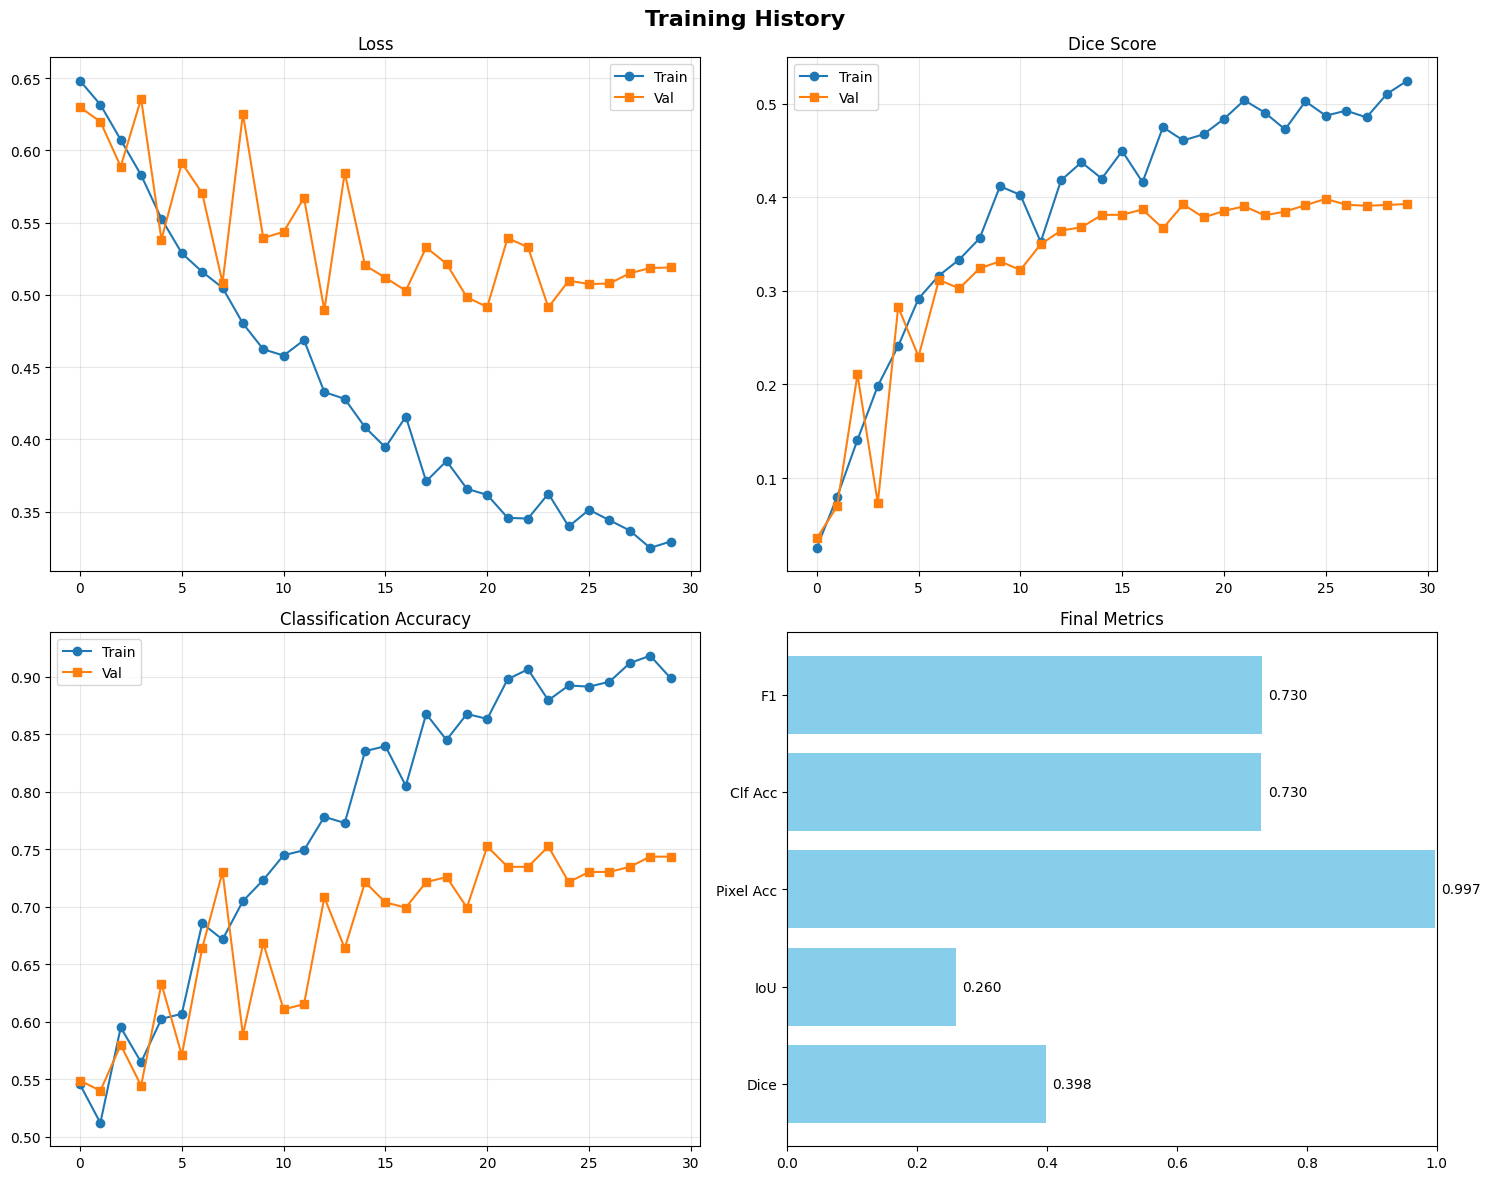

In [27]:
#Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training History', fontsize=16, weight='bold')

axes[0,0].plot(history['train_loss'], 'o-', label='Train')
axes[0,0].plot(history['val_loss'], 's-', label='Val')
axes[0,0].set_title('Loss')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(history['train_dice'], 'o-', label='Train')
axes[0,1].plot(history['val_dice'], 's-', label='Val')
axes[0,1].set_title('Dice Score')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(history['train_acc'], 'o-', label='Train')
axes[1,0].plot(history['val_acc'], 's-', label='Val')
axes[1,0].set_title('Classification Accuracy')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

metrics = ['Dice','IoU','Pixel Acc','Clf Acc','F1']
values = [final['dice'], final['iou'], final['pixel_acc'], final['clf_acc'], final['clf_f1']]
axes[1,1].barh(metrics, values, color='skyblue')
axes[1,1].set_title('Final Metrics')
axes[1,1].set_xlim([0,1])
for i,v in enumerate(values):
    axes[1,1].text(v+0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

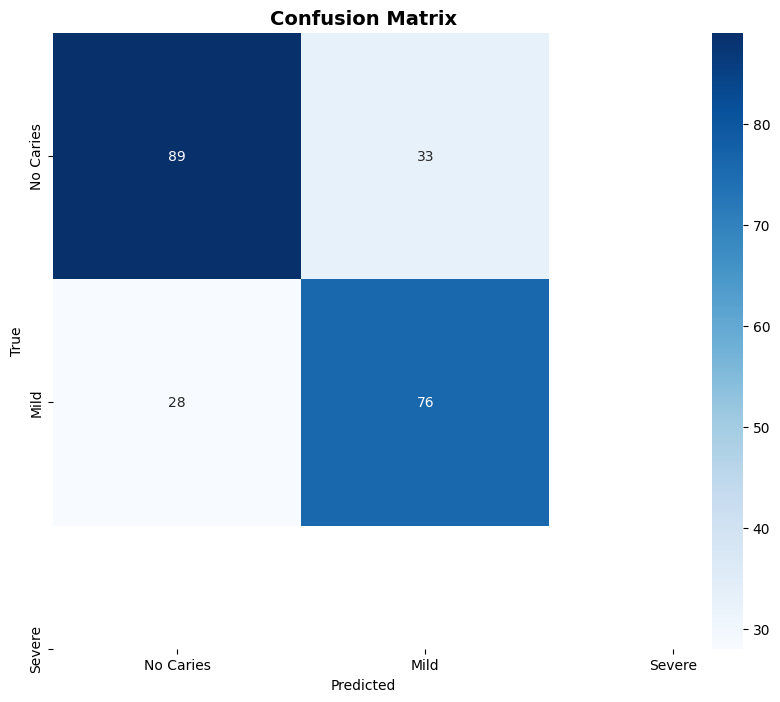

In [28]:
#Confusion Matrix
cm = confusion_matrix(final['labels'], final['preds'])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Caries','Mild','Severe'],
            yticklabels=['No Caries','Mild','Severe'])
plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

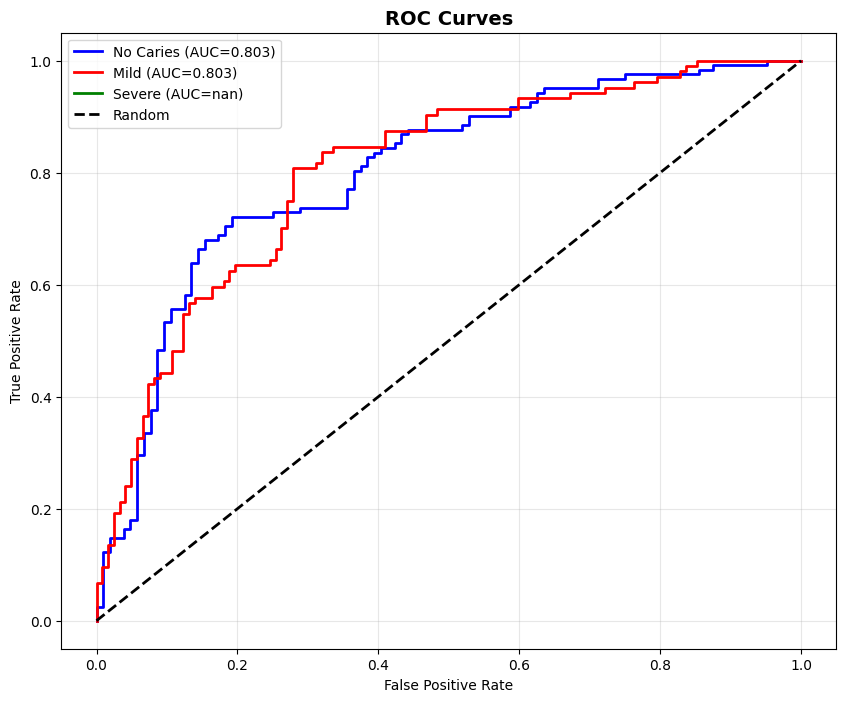

In [29]:
#ROC Curves
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(final['labels'], classes=[0,1,2])
y_score = np.array(final['probs'])

plt.figure(figsize=(10,8))
colors = ['blue','red','green']
names = ['No Caries','Mild','Severe']

for i, c, n in zip(range(3), colors, names):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
    auc = roc_auc_score(y_bin[:,i], y_score[:,i])
    plt.plot(fpr, tpr, color=c, lw=2, label=f'{n} (AUC={auc:.3f})')

plt.plot([0,1], [0,1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('/content/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

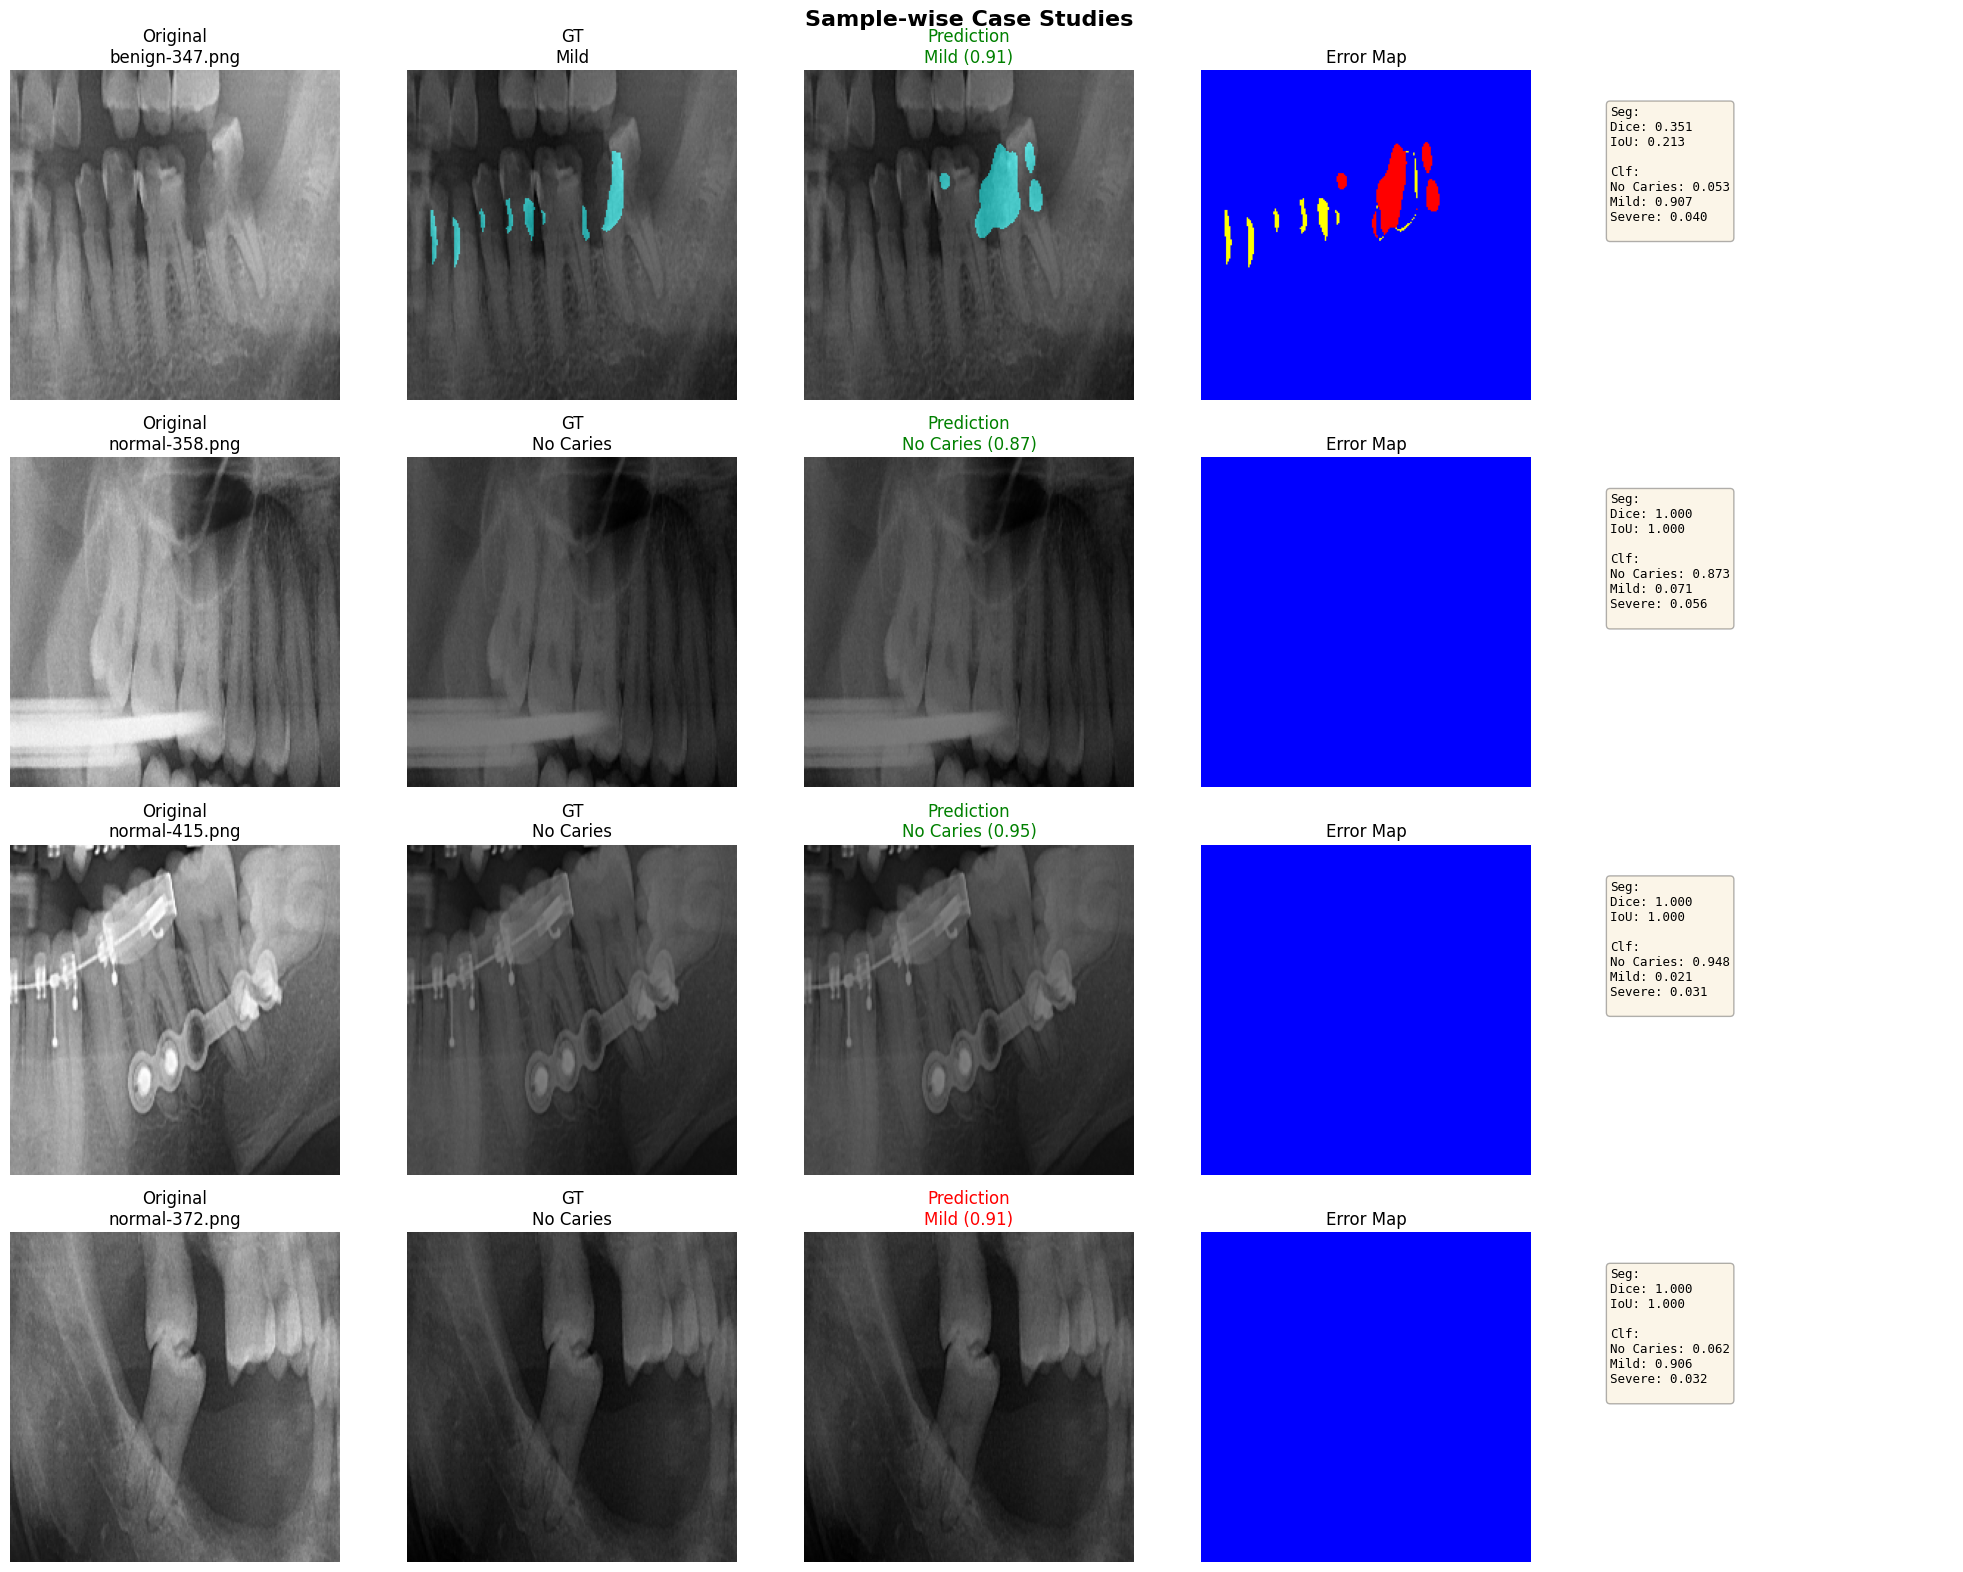

In [30]:
#Case Study and Vizualizations
def denorm(tensor):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return tensor * std + mean

def overlay(img, mask, alpha=0.5):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    if img.shape[0]==3:
        img = np.transpose(img, (1,2,0))
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    colored = np.zeros_like(img)
    if mask.ndim==3:
        mask = mask[0]
    colored[mask>0.5] = [0,1,1]
    return np.clip(img*(1-alpha) + colored*alpha, 0, 1)

def case_studies(model, dataset, device, n=4):
    model.eval()
    idx = np.random.choice(len(dataset), n, replace=False)

    fig, axes = plt.subplots(n, 5, figsize=(20, 4*n))
    if n==1:
        axes = axes.reshape(1,-1)

    names = ['No Caries','Mild','Severe']

    with torch.no_grad():
        for i, si in enumerate(idx):
            img, mask, label, name = dataset[si]
            inp = img.unsqueeze(0).to(device)
            seg_out, clf_out = model(inp)

            pred_mask = torch.sigmoid(seg_out[0]).cpu()
            pred_bin = (pred_mask > 0.5).float()
            probs = F.softmax(clf_out[0], 0).cpu().numpy()
            pred_cls = probs.argmax()

            disp = denorm(img).cpu()
            orig = np.transpose(disp.numpy(), (1,2,0))
            orig = np.clip(orig, 0, 1)

            gt_ov = overlay(disp, mask)
            pred_ov = overlay(disp, pred_mask)

            # Error map
            gt_b = (mask[0].cpu().numpy()>0.5).astype(float)
            pred_b = pred_bin[0].numpy()
            err = np.zeros((gt_b.shape[0], gt_b.shape[1], 3))
            err[gt_b==pred_b] = [0,0,1]
            err[pred_b>gt_b] = [1,0,0]
            err[gt_b>pred_b] = [1,1,0]

            axes[i,0].imshow(orig)
            axes[i,0].set_title(f'Original\n{name[:20]}')
            axes[i,0].axis('off')

            axes[i,1].imshow(gt_ov)
            axes[i,1].set_title(f'GT\n{names[label]}')
            axes[i,1].axis('off')

            axes[i,2].imshow(pred_ov)
            color = 'green' if pred_cls==label else 'red'
            axes[i,2].set_title(f'Prediction\n{names[pred_cls]} ({probs[pred_cls]:.2f})', color=color)
            axes[i,2].axis('off')

            axes[i,3].imshow(err)
            axes[i,3].set_title('Error Map')
            axes[i,3].axis('off')

            dice = dice_coef(seg_out[0:1], mask.unsqueeze(0).to(device)).item()
            iou = iou_score(seg_out[0:1], mask.unsqueeze(0).to(device)).item()
            txt = f"Seg:\nDice: {dice:.3f}\nIoU: {iou:.3f}\n\nClf:\n"
            for j, nm in enumerate(names):
                txt += f"{nm}: {probs[j]:.3f}\n"
            axes[i,4].text(0.1, 0.5, txt, fontsize=9, family='monospace',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
            axes[i,4].axis('off')

    plt.suptitle('Sample-wise Case Studies', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('/content/case_studies.png', dpi=300, bbox_inches='tight')
    plt.show()

case_studies(model, val_dataset, device, 4)

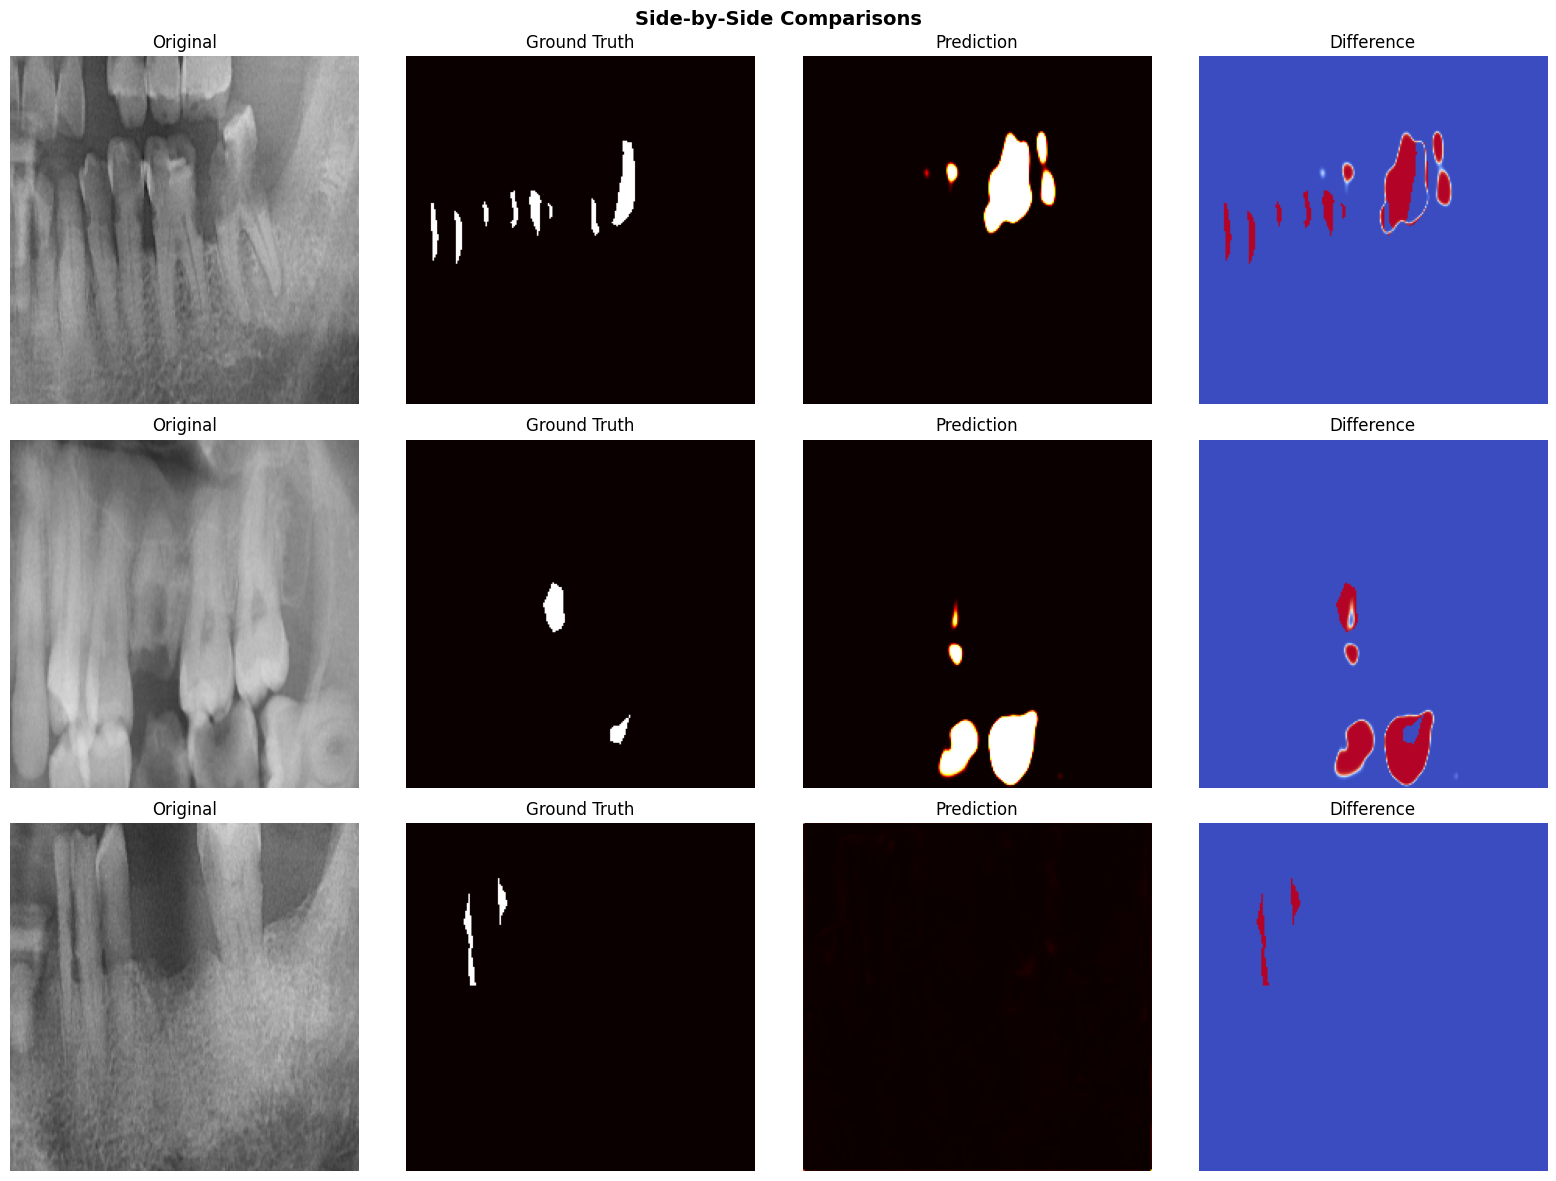

In [31]:
# Side-by-side
def side_by_side(model, dataset, device, n=3):
    model.eval()
    idx = np.random.choice(len(dataset), n, replace=False)

    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n==1:
        axes = axes.reshape(1,-1)

    with torch.no_grad():
        for i, si in enumerate(idx):
            img, mask, _, name = dataset[si]
            inp = img.unsqueeze(0).to(device)
            seg_out, _ = model(inp)
            pred = torch.sigmoid(seg_out[0]).cpu()

            disp = denorm(img).cpu()
            orig = np.transpose(disp.numpy(), (1,2,0))
            orig = np.clip(orig, 0, 1)

            axes[i,0].imshow(orig)
            axes[i,0].set_title('Original')
            axes[i,0].axis('off')

            axes[i,1].imshow(mask[0].cpu(), cmap='hot')
            axes[i,1].set_title('Ground Truth')
            axes[i,1].axis('off')

            axes[i,2].imshow(pred[0], cmap='hot')
            axes[i,2].set_title('Prediction')
            axes[i,2].axis('off')

            diff = np.abs(mask[0].cpu().numpy() - pred[0].numpy())
            axes[i,3].imshow(diff, cmap='coolwarm', vmin=0, vmax=1)
            axes[i,3].set_title('Difference')
            axes[i,3].axis('off')

    plt.suptitle('Side-by-Side Comparisons', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig('/content/side_by_side.png', dpi=300, bbox_inches='tight')
    plt.show()

side_by_side(model, val_dataset, device, 3)

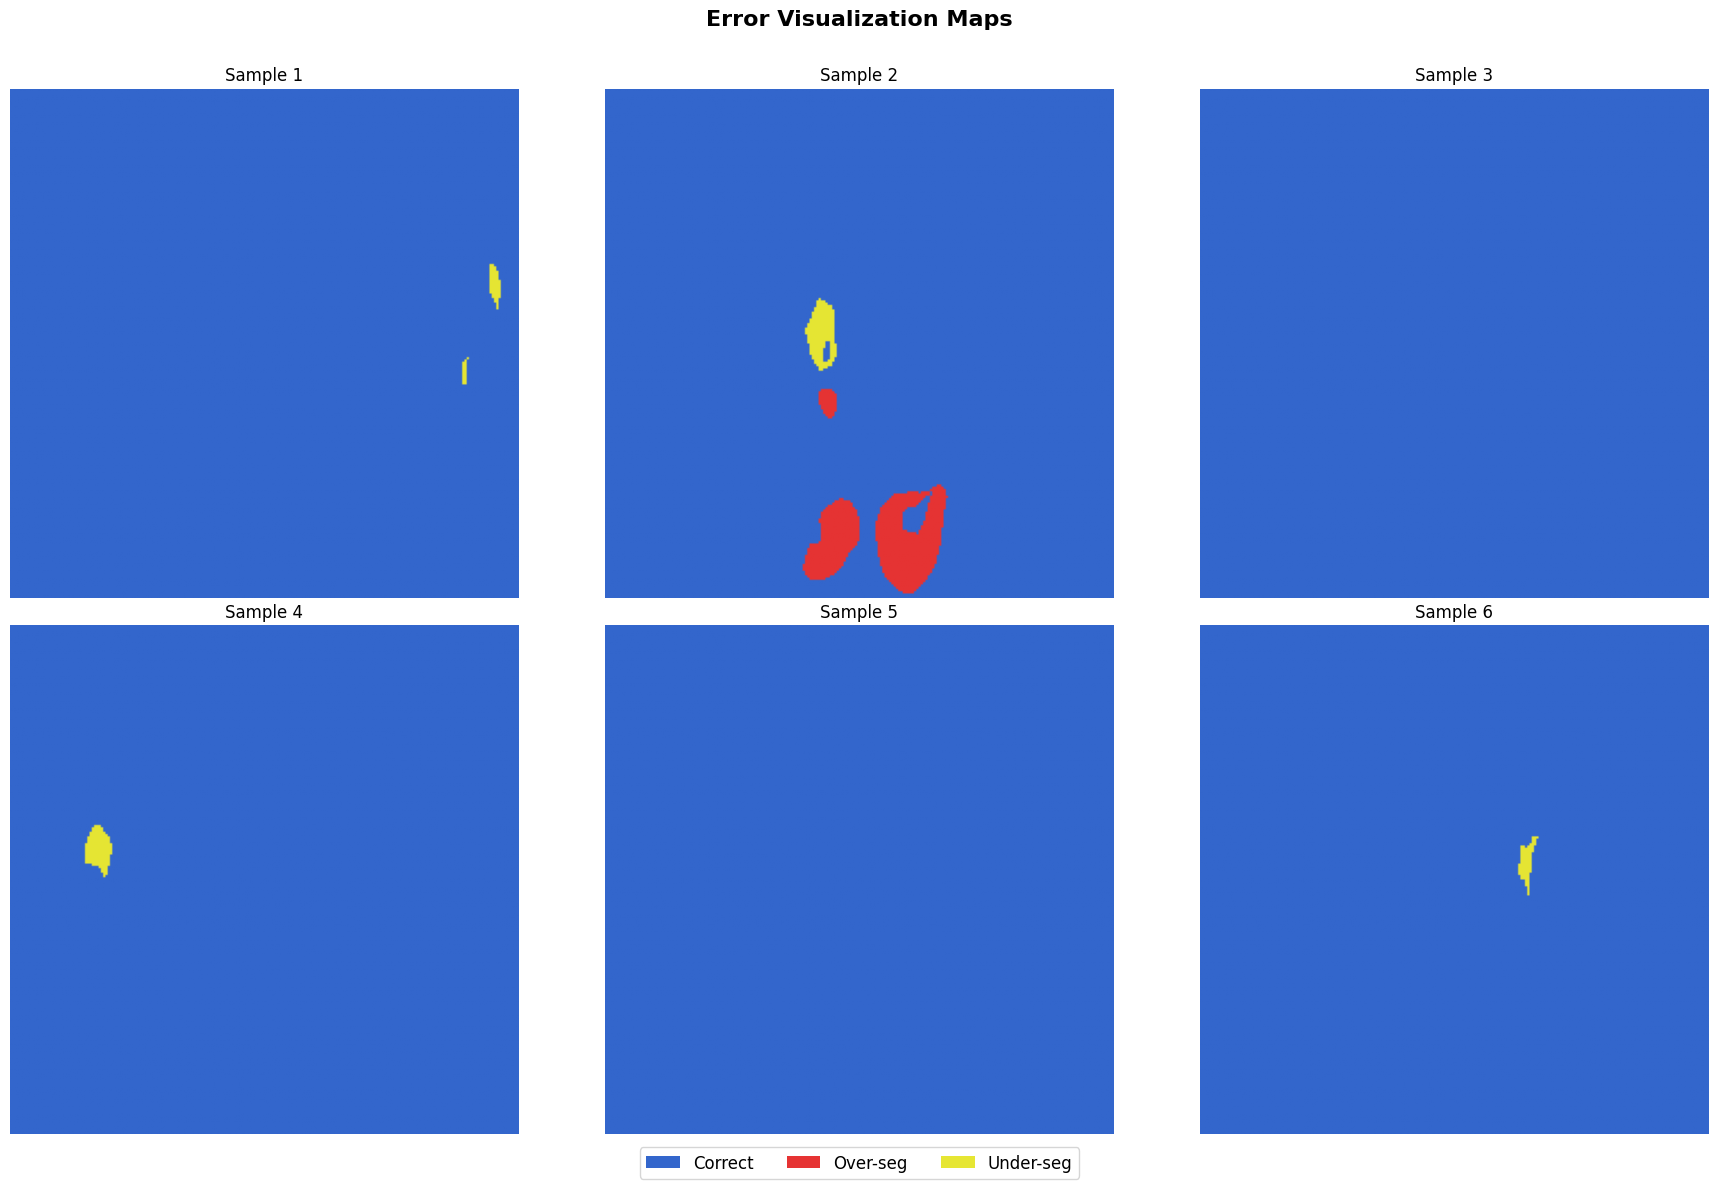

In [36]:
# Error Maps
def error_maps(model, dataset, device, n=6):
    model.eval()
    idx = np.random.choice(len(dataset), n, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    with torch.no_grad():
        for i, si in enumerate(idx):
            img, mask, _, _ = dataset[si]
            inp = img.unsqueeze(0).to(device)
            seg_out, _ = model(inp)

            pred_b = (torch.sigmoid(seg_out[0,0]).cpu().numpy()>0.5).astype(float)
            gt_b = (mask[0].cpu().numpy()>0.5).astype(float)

            err = np.zeros((gt_b.shape[0], gt_b.shape[1], 3))
            err[gt_b==pred_b] = [0.2,0.4,0.8]
            err[pred_b>gt_b] = [0.9,0.2,0.2]
            err[gt_b>pred_b] = [0.9,0.9,0.2]

            axes[i].imshow(err)
            axes[i].set_title(f'Sample {i+1}')
            axes[i].axis('off')

    from matplotlib.patches import Patch
    legend = [
        Patch(facecolor=[0.2,0.4,0.8], label='Correct'),
        Patch(facecolor=[0.9,0.2,0.2], label='Over-seg'),
        Patch(facecolor=[0.9,0.9,0.2], label='Under-seg')
    ]
    fig.legend(handles=legend, loc='lower center', ncol=3, fontsize=12)

    plt.suptitle('Error Visualization Maps', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0,0.03,1,0.97])
    plt.savefig('/content/error_maps.png', dpi=300, bbox_inches='tight')
    plt.show()

error_maps(model, val_dataset, device, 6)

Hausdorff:   0%|          | 0/8 [00:00<?, ?it/s]


Hausdorff Distance:
  Mean: 44.0154 px
  Std: 35.1836 px
  Median: 29.0689 px


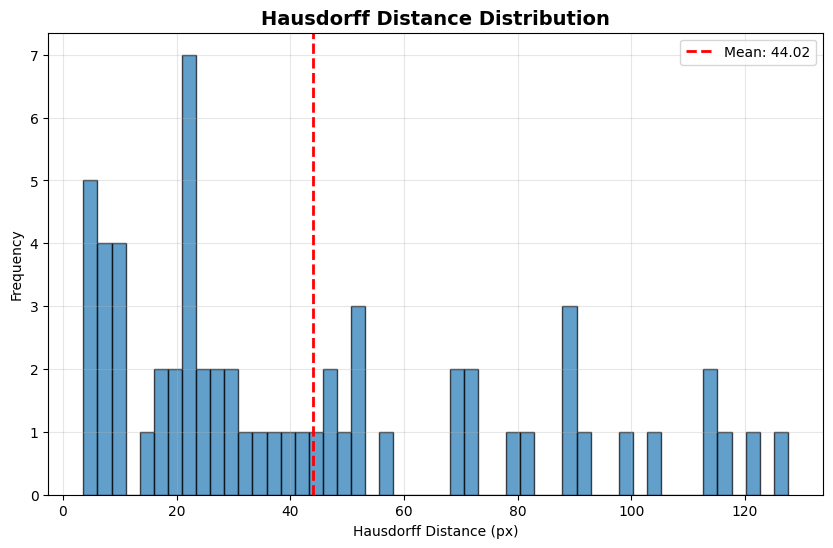

In [34]:
#Hausdorff Distance
def compute_hausdorff(model, loader, device):
    model.eval()
    dists = []

    with torch.no_grad():
        for imgs, masks, _, _ in tqdm(loader, desc='Hausdorff'):
            imgs = imgs.to(device)
            seg_out, _ = model(imgs)
            pred = (torch.sigmoid(seg_out) > 0.5).cpu().numpy()
            gt = masks.cpu().numpy()

            for p, g in zip(pred, gt):
                pp = np.argwhere(p[0]>0.5)
                gp = np.argwhere(g[0]>0.5)
                if len(pp)>0 and len(gp)>0:
                    hd = max(directed_hausdorff(pp, gp)[0], directed_hausdorff(gp, pp)[0])
                    dists.append(hd)
    return dists

hd_dists = compute_hausdorff(model, val_loader, device)
mean_hd = np.mean(hd_dists)

print(f"\nHausdorff Distance:")
print(f"  Mean: {mean_hd:.4f} px")
print(f"  Std: {np.std(hd_dists):.4f} px")
print(f"  Median: {np.median(hd_dists):.4f} px")

plt.figure(figsize=(10,6))
plt.hist(hd_dists, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_hd, color='red', linestyle='--', lw=2, label=f'Mean: {mean_hd:.2f}')
plt.xlabel('Hausdorff Distance (px)')
plt.ylabel('Frequency')
plt.title('Hausdorff Distance Distribution', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('/content/hausdorff.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
report = {
    'Segmentation': {
        'Dice': f"{final['dice']:.4f}",
        'IoU': f"{final['iou']:.4f}",
        'Pixel Accuracy': f"{final['pixel_acc']:.4f}",
        'Sensitivity': f"{final['sens']:.4f}",
        'Specificity': f"{final['spec']:.4f}",
        'Hausdorff (mean)': f"{mean_hd:.4f} px"
    },
    'Classification': {
        'Accuracy': f"{final['clf_acc']:.4f}",
        'Precision': f"{final['clf_prec']:.4f}",
        'Recall': f"{final['clf_rec']:.4f}",
        'F1-Score': f"{final['clf_f1']:.4f}"
    }
}

print('\n'+'='*80)
print('FINAL COMPREHENSIVE REPORT'.center(80))
print('='*80+'\n')

for cat, metrics in report.items():
    print(f"\n{cat}:")
    print('-'*60)
    for k, v in metrics.items():
        print(f"  {k:<35} {v:>20}")

print('\n'+'='*80)

import json
with open('/content/metrics_report.json', 'w') as f:
    json.dump(report, f, indent=4)

print("\n✓ Report saved: /content/metrics_report.json")
print("\n" + "="*80)
print("ALL DELIVERABLES COMPLETE!".center(80))
print("="*80)


                           FINAL COMPREHENSIVE REPORT                           


Segmentation:
------------------------------------------------------------
  Dice                                              0.3984
  IoU                                               0.2599
  Pixel Accuracy                                    0.9968
  Sensitivity                                       0.3864
  Specificity                                       0.9984
  Hausdorff (mean)                              44.0154 px

Classification:
------------------------------------------------------------
  Accuracy                                          0.7301
  Precision                                         0.7315
  Recall                                            0.7301
  F1-Score                                          0.7304


✓ Report saved: /content/metrics_report.json

                           ALL DELIVERABLES COMPLETE!                           


📤 Please upload a dental X-ray image (PNG/JPG)...


Saving benign-161.png to benign-161.png


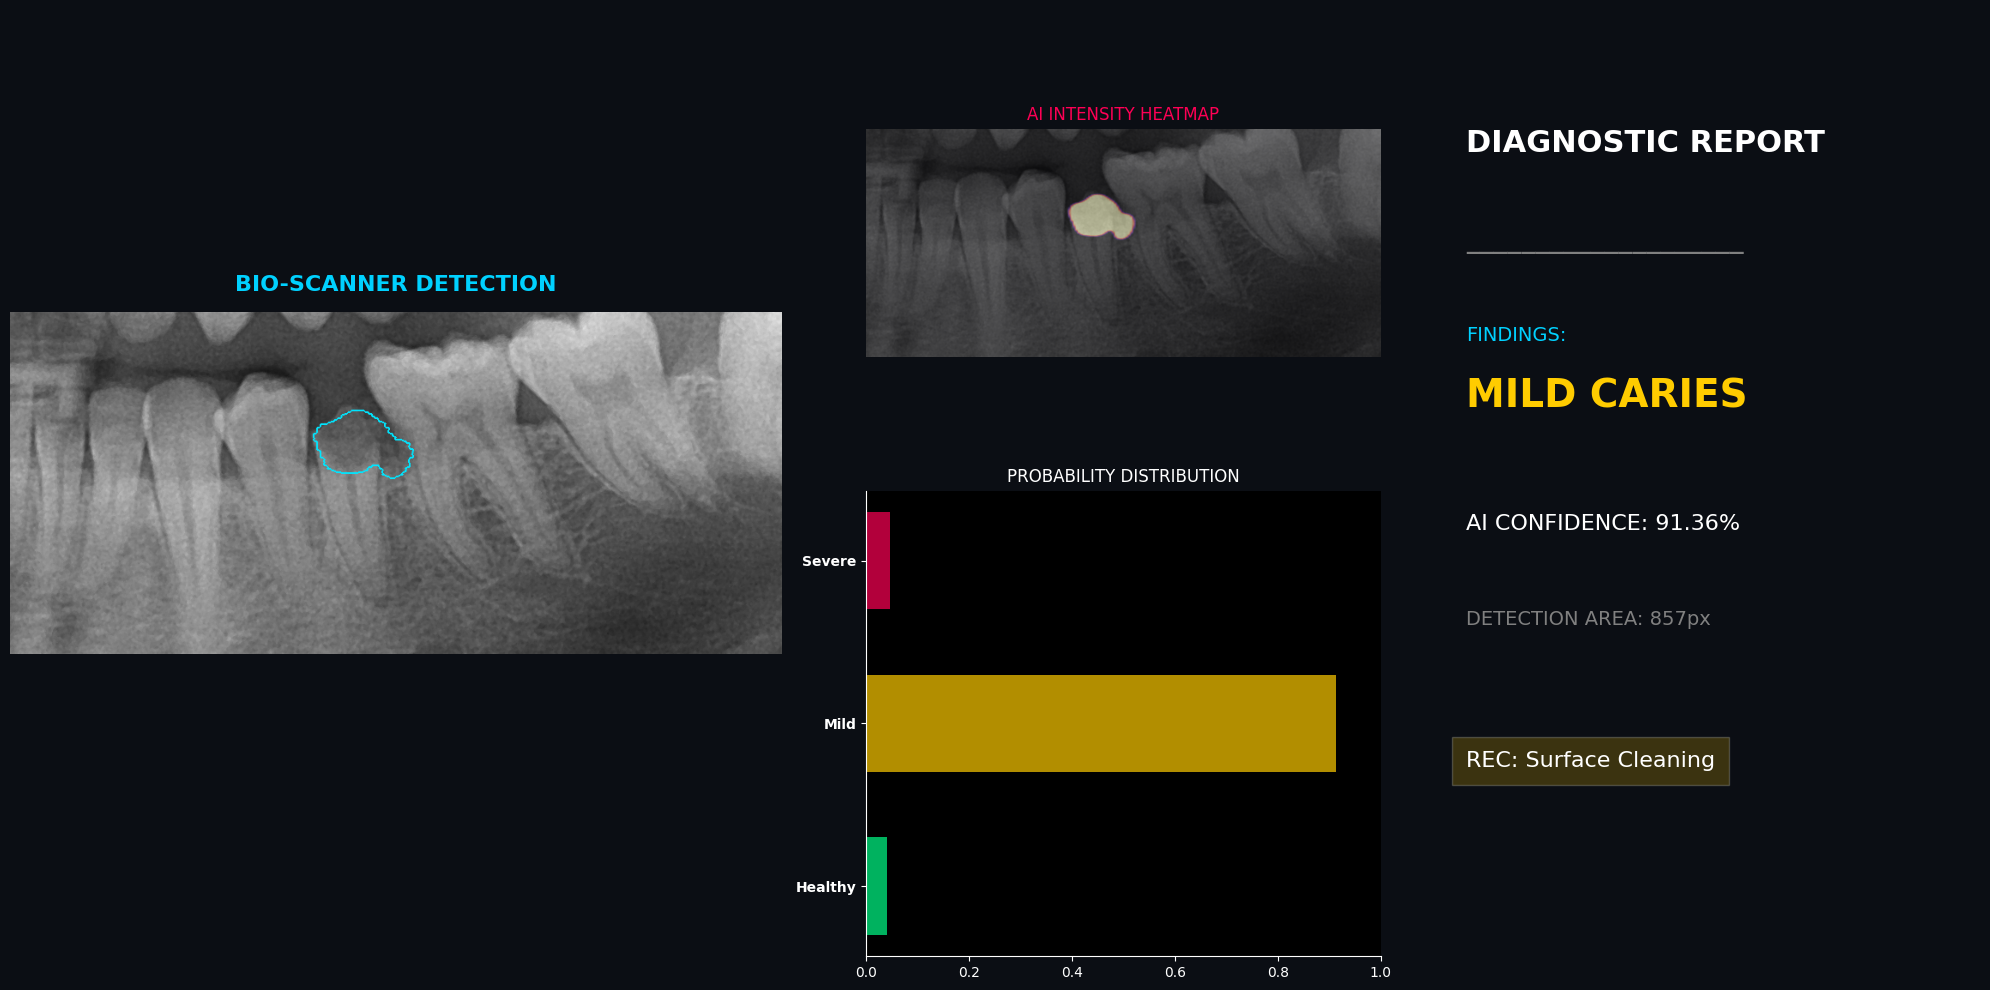

In [49]:
import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation
from google.colab import files

def run_pro_dashboard_upload():
    print("Please upload a dental X-ray image (PNG/JPG)...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    image_path = list(uploaded.keys())[0]

    #Pre-process
    model.eval()
    raw_img = cv2.imread(image_path)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    h, w, _ = raw_img.shape

    #Model normalization
    input_res = cv2.resize(raw_img, (224, 224))
    img_tensor = input_res / 255.0
    img_tensor = (img_tensor - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img_tensor = torch.from_numpy(img_tensor).permute(2, 0, 1).float().unsqueeze(0).to(device)

    #Inference
    with torch.no_grad():
        seg_out, clf_out = model(img_tensor)
        probs = F.softmax(clf_out, dim=1).squeeze().cpu().numpy()
        pred_idx = np.argmax(probs)
        conf = probs[pred_idx]

        mask = torch.sigmoid(seg_out).squeeze().cpu().numpy()
        mask_binary = (mask > 0.5).astype(np.uint8)
        mask_resized = cv2.resize(mask_binary, (w, h))

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 10), facecolor='#0B0E14')
    gs = fig.add_gridspec(2, 3, width_ratios=[1.5, 1, 1])

    ax1 = fig.add_subplot(gs[:, 0])
    glow_outline = segmentation.mark_boundaries(raw_img/255.0, mask_resized, color=(0, 0.9, 1), mode='thick')
    ax1.imshow(glow_outline)
    ax1.set_title("BIO-SCANNER DETECTION", color='#00D1FF', fontsize=16, weight='bold', pad=15)
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(raw_img)
    mask_h = cv2.resize(mask, (w, h))
    ax2.imshow(mask_h, cmap='magma', alpha=0.5)
    ax2.set_title("AI INTENSITY HEATMAP", color='#FF0055', fontsize=12)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[1, 1])
    labels = ['Healthy', 'Mild', 'Severe']
    colors = ['#00FF88', '#FFCC00', '#FF0055']
    y_pos = np.arange(len(labels))
    ax3.barh(y_pos, probs, color=colors, alpha=0.7, height=0.6)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(labels, color='white', weight='bold')
    ax3.set_xlim(0, 1)
    ax3.set_title("PROBABILITY DISTRIBUTION", color='white', fontsize=12)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    #Final Report
    ax4 = fig.add_subplot(gs[:, 2])
    ax4.axis('off')
    status_text = ["HEALTHY", "MILD CARIES", "SEVERE CARIES"][pred_idx]
    status_color = colors[pred_idx]

    ax4.text(0, 0.85, "DIAGNOSTIC REPORT", color='white', fontsize=22, weight='bold')
    ax4.text(0, 0.75, "_"*20, color='gray', fontsize=20)
    ax4.text(0, 0.65, "FINDINGS:", color='#00D1FF', fontsize=14)
    ax4.text(0, 0.58, status_text, color=status_color, fontsize=28, weight='bold')
    ax4.text(0, 0.45, f"AI CONFIDENCE: {conf*100:.2f}%", color='white', fontsize=16)
    ax4.text(0, 0.35, f"DETECTION AREA: {np.sum(mask_binary)}px", color='gray', fontsize=14)

    rec = "Routine Checkup" if pred_idx == 0 else ("Surface Cleaning" if pred_idx == 1 else "Immediate Treatment")
    ax4.text(0, 0.20, f"REC: {rec}", color='white', fontsize=16, bbox=dict(facecolor=status_color, alpha=0.2, pad=10))

    plt.tight_layout()
    plt.show()
    os.remove(image_path)

run_pro_dashboard_upload()